In [383]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime


import networkx as nx
import tensorflow_hub as hub
from gensim.models import Word2Vec

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [384]:
model_url='https://tfhub.dev/google/universal-sentence-encoder/4'
model=hub.load(model_url)


In [385]:
# extract the title and the date from the dossier
dossier = pd.read_csv('./data/raw/cv.csv')

time_val = dossier['date'].astype(str).tolist()
documents = dossier['full_text'].astype(str).tolist()

In [386]:
def extract_embeddings(documents, model):
    embeddings = []
    for document in documents:
        # extract the sentences and compute the embeddings
        sentences = document.split('. ')
        embedding = model(sentences)

        # compute the mean of the embeddings
        embeddings.append(np.mean(embedding, axis=0))

    return np.array(embeddings)

embeddings = extract_embeddings(documents, model)


In [387]:
def convert_date(date):
    object = datetime.strptime(date, "%m/%d/%Y")
    return int(object.timestamp())


def convert_dates(dates):
    # convert the date of the dossier to an integer value
    time = np.array([convert_time(date) for date in dates])

    # normalize the integer values between 0 and 1
    time = (time - time.min())/(time.max() - time.min())

    return time


def date_similarity(time, decay_rate):
    similarity = np.zeros((time.size, time.size))

    for i in range(time.size):
        for j in range(time.size):
            # compute the exponential decay between the dates
            norm = np.abs(time[i] - time[j])
            similarity[i,j] = np.exp(-decay_rate*norm)
            
    return similarity


In [ ]:
# Step 2: Generate random walks
def generate_random_walks(G, num_walks, walk_length):
    walks = []
    for _ in range(num_walks):
        for node in G.nodes():
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                next_node = random.choice(list(G.neighbors(cur)))
                walk.append(next_node)
            walks.append([str(node) for node in walk])
    return walks


In [573]:
# compute the normalized values of the dates
time_vals = convert_dates(time_val)

# compute the similarity matrix based on the dates
sim_date = date_similarity(time_vals, 2)



# compute the similarity matrix based on the cosine 
matrix = cosine_similarity(embeddings)
sim_matrix = (matrix - matrix.min())/(matrix.max() - matrix.min())

# compute the geometric mean between the similarity matrices
similarity = np.sqrt(sim_matrix * sim_date)
similarity = np.where(similarity > 0.8, 1, 0)


# create the weighted graph and perform the random walk
G = nx.from_numpy_array(similarity)
random_walks = generate_random_walks(G, 400, 50)

In [574]:
# Step 3: Learn embeddings with Word2Vec
word_models = Word2Vec(sentences=random_walks, vector_size=100, window=5, min_count=1, sg=1)
new_embeddings = np.array([word_models.wv[str(node)] for node in G.nodes])

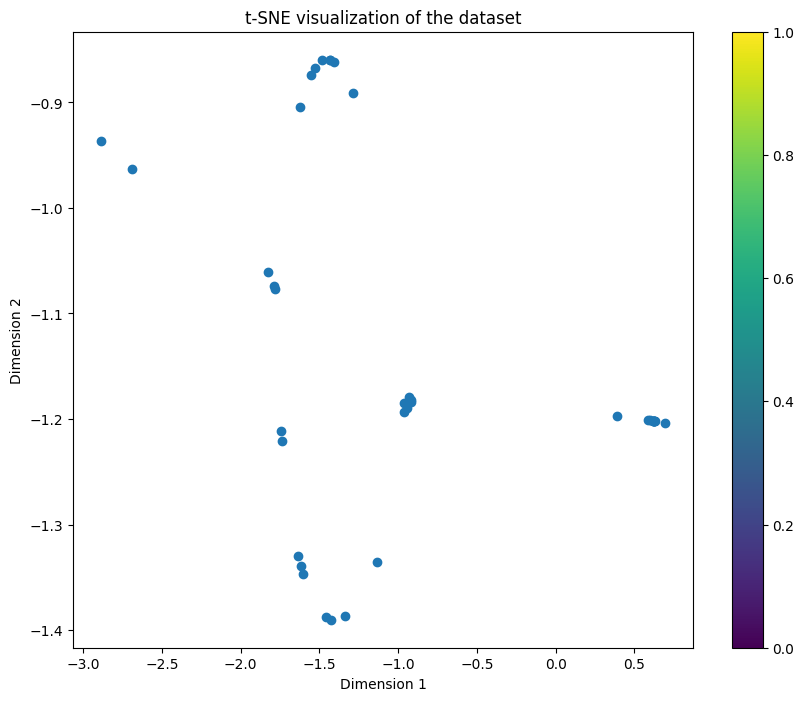

In [575]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



tsne = TSNE(n_components=2, random_state=42)  
X_reduced = tsne.fit_transform(embeddings)

# Plotting the result
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])  
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of the dataset')
plt.show()

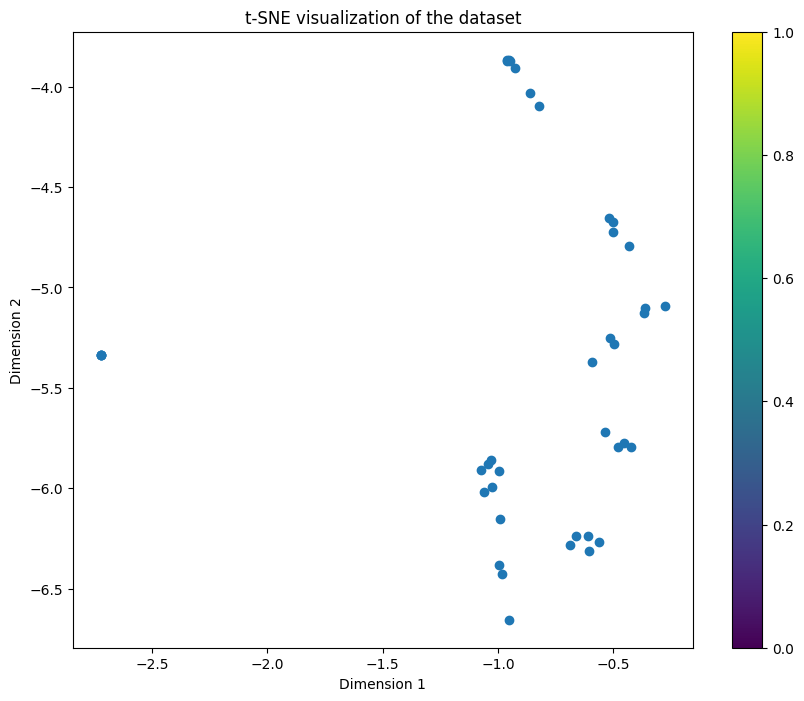

In [576]:
tsne = TSNE(n_components=2, random_state=42)  
X_reduced = tsne.fit_transform(new_embeddings)

# Plotting the result
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1]) 
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of the dataset')
plt.show()